In [1]:
from nbodykit.lab import *
from nbodykit import style, setup_logging

import corner
from tqdm import tqdm
import numpy as np
import seaborn as sns
import MAS_library as MASL
import Pk_library as PKL
import matplotlib.pyplot as plt

import sys, pickle, time, os
# sys.path.insert(1, './')
from run_nbk_dict import COSMOPAR, order_dimension, order_folders, cosmological_pars, \
                         VarCosmoPar, fiducial_vals
from run_nbk_funcs import cosmo_parser, PacMan, Hartlap, error_message

# nbodykit tool to read custom (non-standard) catalogue file type
from nbodykit.io.base import FileType
# nbodykit tool to creae custom subclass od CatalogSource
from nbodykit.source.catalog.file import FileCatalogFactory
# nbodykit cosmology parameters initialization
from nbodykit.lab import cosmology

from readfof import FoF_catalog
from torch import flatten, from_numpy

/home/fuffolo97/anaconda3/envs/nbodykit-envB/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
number_coeff_pk = 159
files_to_proecss = os.listdir('./Pk-files/')

In [3]:
nfile_fiducial, nfile_fiducial_rsd = "a", "a"

for i in range(len(files_to_proecss)):
    fn = files_to_proecss[i]
    if "fiducial" in fn and "rsd" not in fn: nfile_fiducial = fn
    if "fiducial" in fn and "rsd"     in fn: nfile_fiducial_rsd = fn

assert type(nfile_fiducial) == type(nfile_fiducial_rsd) == str

fiducial_pk = []
fiducial_rsd_pk = []

with open("./Pk-files/"+nfile_fiducial, "rb") as f:
    while True:
        try:
            fiducial_pk.append(pickle.load(f))
        except EOFError:
            break

with open("./Pk-files/"+nfile_fiducial_rsd, "rb") as f:
    while True:
        try:
            fiducial_rsd_pk.append(pickle.load(f))
        except EOFError:
            break

In [4]:
fiducial_pk_pk, fiducial_rsd_pk_pk = [], []
for i in range(len(fiducial_pk)):
    fiducial_pk_pk.append(fiducial_pk[i]["power"].real  - fiducial_pk[i].attrs['shotnoise'] )
    fiducial_rsd_pk_pk.append(fiducial_rsd_pk[i]["power"].real  - fiducial_rsd_pk[i].attrs['shotnoise'] )

fiducial_pk_mean = np.mean(fiducial_pk_pk, axis=0)
fiducial_rsd_pk_mean = np.mean(fiducial_rsd_pk_pk, axis=0)

### Power Spectrum plot

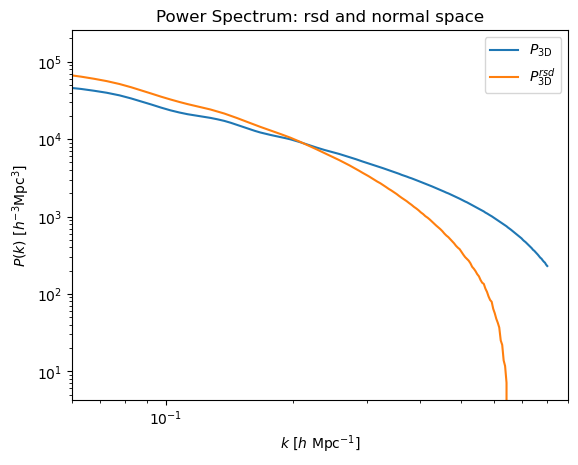

In [5]:
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_mean, label=r"$P_\mathrm{3D}$")
plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_mean, label=r"$P_\mathrm{3D}^{rsd}$")

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title("Power Spectrum: rsd and normal space")
plt.xlim(0.06, 0.9)
plt.savefig('Power_Spectrum_rsd_normal_space.png', format='png')

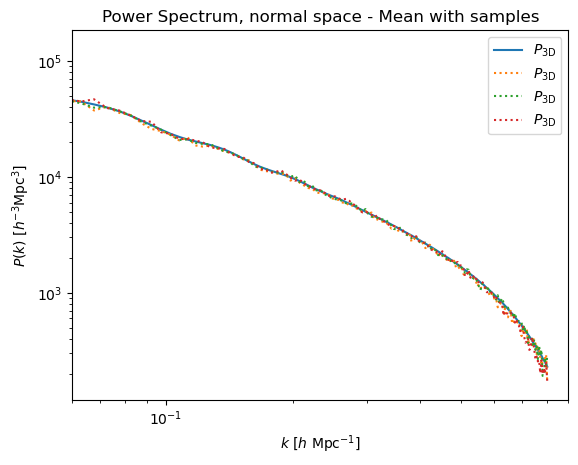

In [6]:
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_mean, label=r"$P_\mathrm{3D}$")
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_pk[0], label=r"$P_\mathrm{3D}$", linestyle="dotted")
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_pk[10], label=r"$P_\mathrm{3D}$", linestyle="dotted")
plt.loglog(fiducial_pk[0]['k'], fiducial_pk_pk[100], label=r"$P_\mathrm{3D}$", linestyle="dotted")
# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title("Power Spectrum, normal space - Mean with samples")
plt.xlim(0.06, 0.9)
plt.savefig('Power_Spectrum_normal_with_sample.png', format='png')

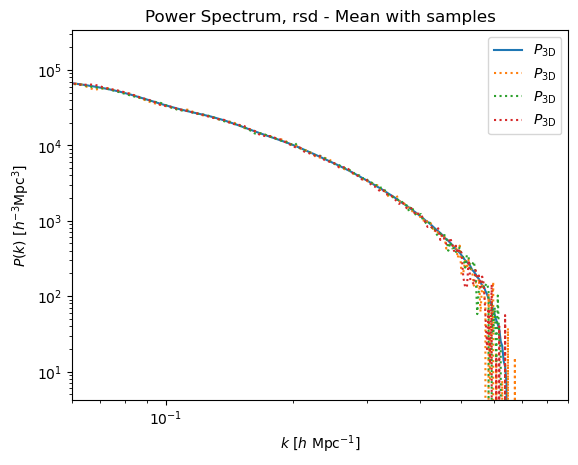

In [7]:
plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_mean, label=r"$P_\mathrm{3D}$")
plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_pk[0], label=r"$P_\mathrm{3D}$", linestyle="dotted")
plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_pk[10], label=r"$P_\mathrm{3D}$", linestyle="dotted")
plt.loglog(fiducial_pk[0]['k'], fiducial_rsd_pk_pk[100], label=r"$P_\mathrm{3D}$", linestyle="dotted")
# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.title("Power Spectrum, rsd - Mean with samples")
plt.xlim(0.06, 0.9)
plt.savefig('Power_Spectrum_rsd_with_sample.png', format='png')

### Power Spectrum and Wavelet Scatering Transfomr plots

In [5]:
cons_pk, cons_rsd_pk = [], []
with open("./ZZ_results/constrains_pk.res", "rb") as f:
    while True:
        try:
            cons_pk.append(pickle.load(f))
        except EOFError:
            break
with open("./ZZ_results/constrains_rsd_pk.res", "rb") as f:
    while True:
        try:
            cons_rsd_pk.append(pickle.load(f))
        except EOFError:
            break

In [6]:
cons_wst, cons_rsd_wst = [], []
with open("./ZZ_results/constrains_wst.res", "rb") as f:
    while True:
        try:
            cons_wst.append(pickle.load(f))
        except EOFError:
            break
with open("./ZZ_results/constrains_rsd_wst.res", "rb") as f:
    while True:
        try:
            cons_rsd_wst.append(pickle.load(f))
        except EOFError:
            break

In [7]:
np.shape(cons_wst)

(1, 7, 7)

In [8]:
mean_vals = np.array((0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1))

In [9]:
Bins = 450
n_points = 1000000
x_Ob  = np.linspace(0.3125, 0.3225, n_points)
x_Om  = np.linspace(0.025,  0.075,  n_points)
x_h   = np.linspace(0,      1.25,   n_points)
x_ns  = np.linspace(0.47,   1.5,    n_points)
x_s8  = np.linspace(0.57,   1.07,   n_points)
x_Mnu = np.linspace(-0.6,   0.6,    n_points)

x_vecs = [x_Ob, x_Om, x_h, x_ns, x_s8, 0, x_Mnu]

In [10]:
data_wst_n  = np.random.multivariate_normal(mean=mean_vals, cov=cons_wst[0],     size=350000)
data_wst_rd = np.random.multivariate_normal(mean=mean_vals, cov=cons_rsd_wst[0], size=350000)
data_pk_n   = np.random.multivariate_normal(mean=mean_vals, cov=cons_pk[0],      size=350000)
data_pk_rd  = np.random.multivariate_normal(mean=mean_vals, cov=cons_rsd_pk[0],  size=350000)

/tmp/ipykernel_25062/1602212984.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_wst_n  = np.random.multivariate_normal(mean=mean_vals, cov=cons_wst[0],     size=350000)
/tmp/ipykernel_25062/1602212984.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_wst_rd = np.random.multivariate_normal(mean=mean_vals, cov=cons_rsd_wst[0], size=350000)
/tmp/ipykernel_25062/1602212984.py:3: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_pk_n   = np.random.multivariate_normal(mean=mean_vals, cov=cons_pk[0],      size=350000)
/tmp/ipykernel_25062/1602212984.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data_pk_rd  = np.random.multivariate_normal(mean=mean_vals, cov=cons_rsd_pk[0],  size=350000)


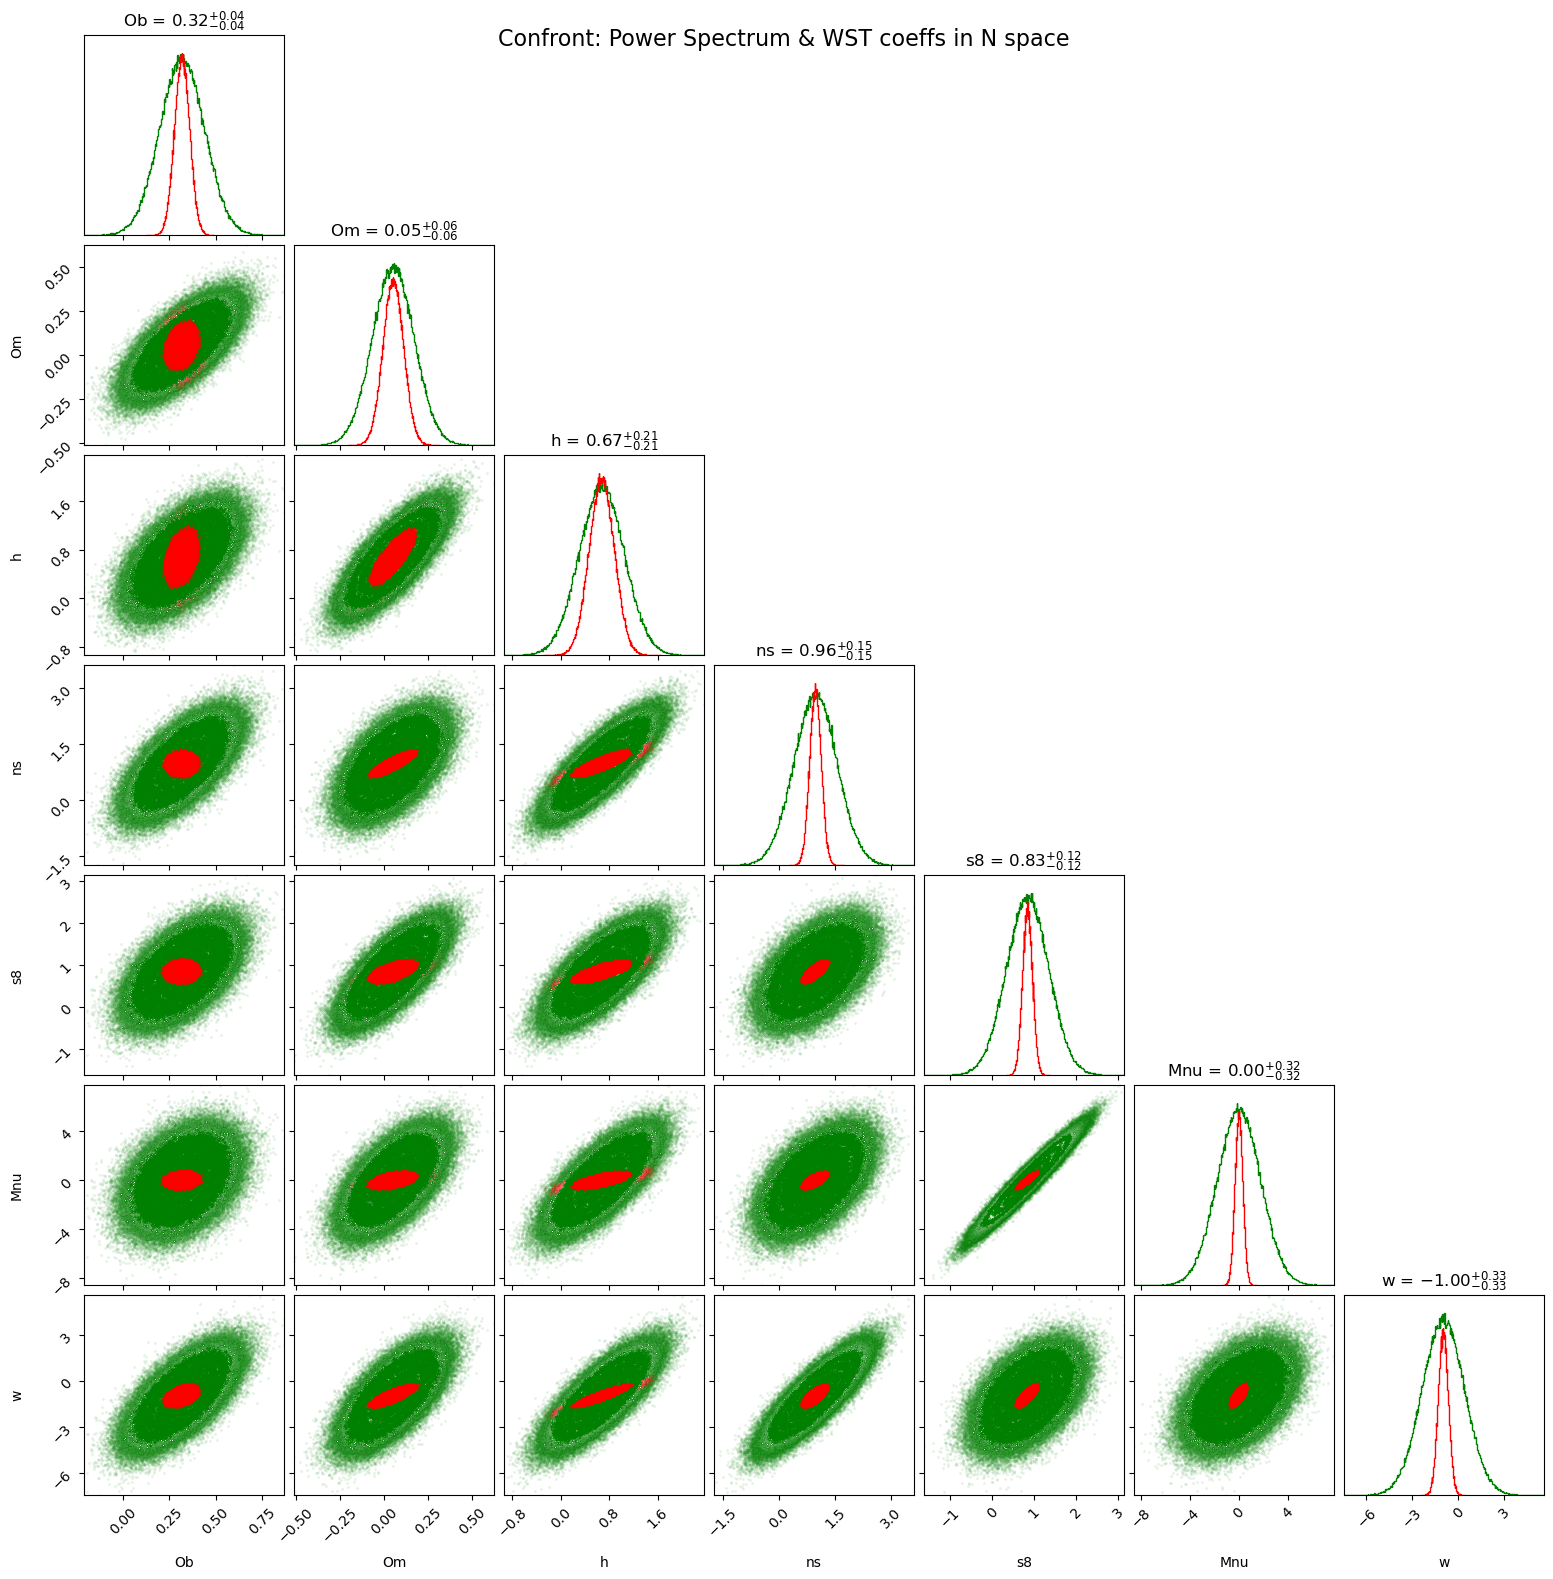

In [14]:
figure1 = corner.corner(data_pk_n, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu','w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"}
                       )
corner.corner(data_wst_n, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                       fig=figure1)

figure1.suptitle('Confront: Power Spectrum & WST coeffs in N space', fontsize=16)
plt.savefig("PK_coeffs_N_RD.png")
plt.show();

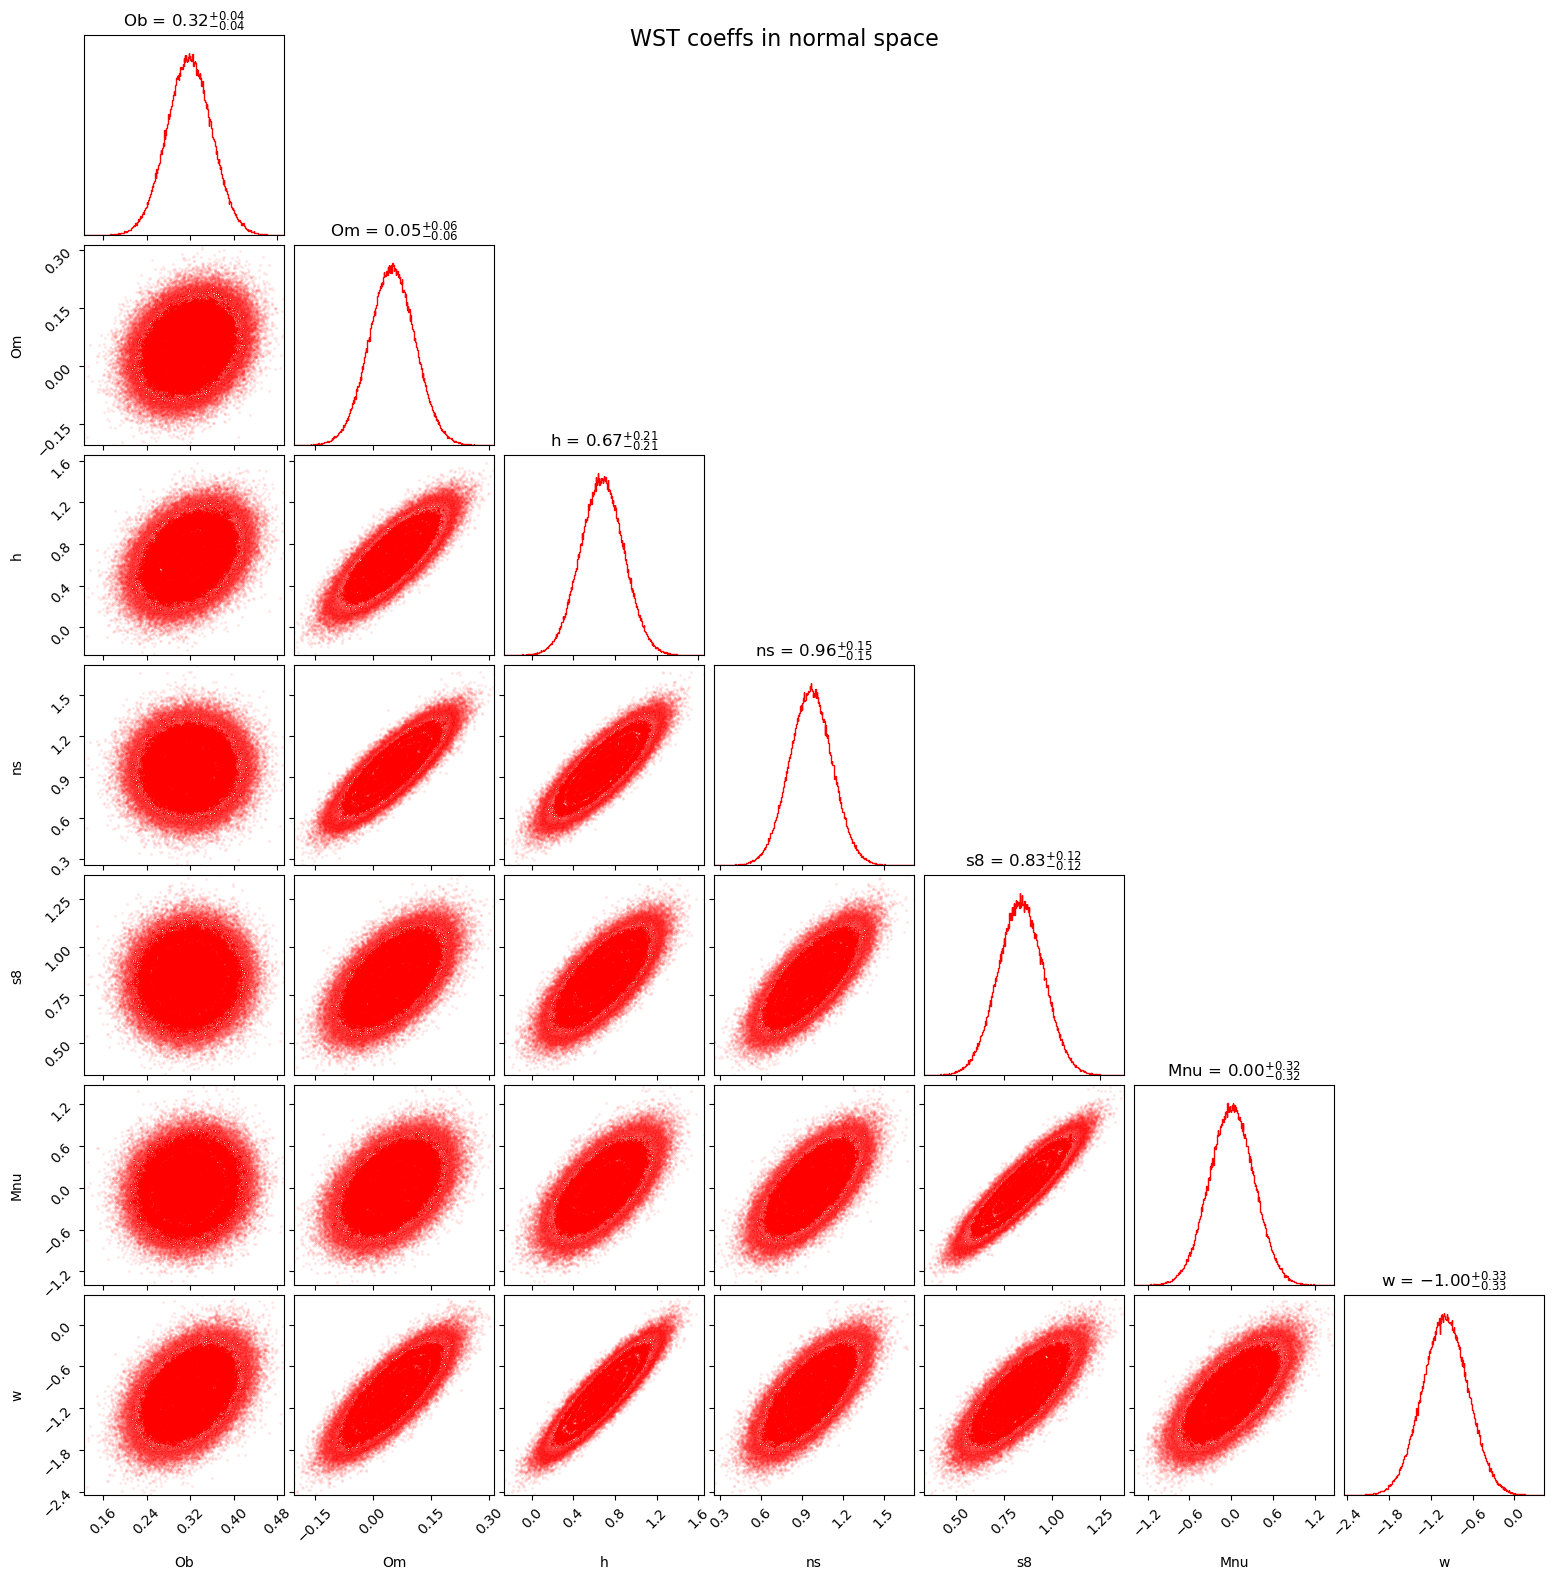

In [15]:
corner.corner(data_wst_n, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"}
                       )
plt.suptitle('WST coeffs in normal space', fontsize=16)
plt.savefig("WST_coeffs_N.png")
plt.show();

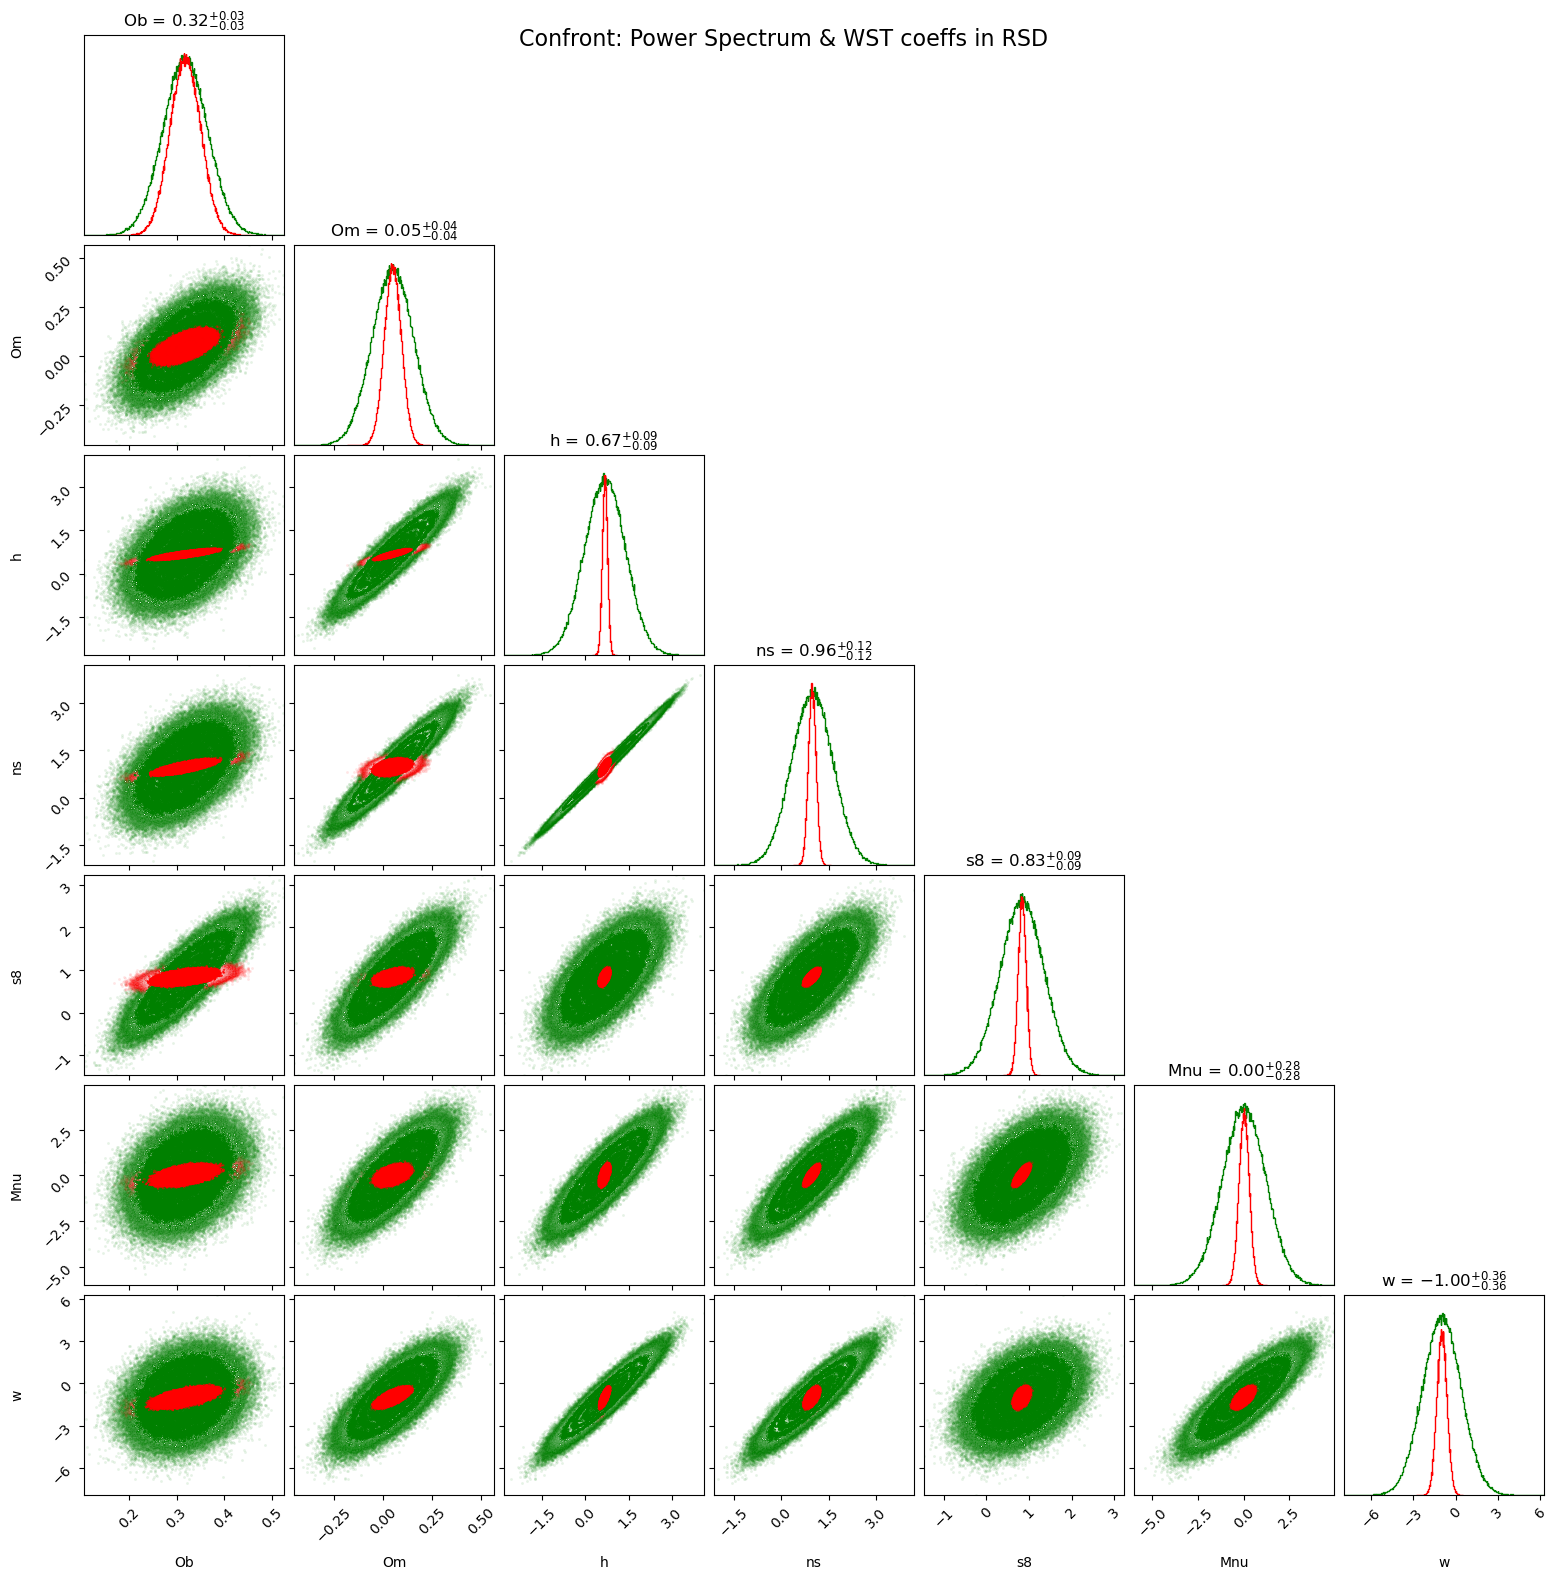

In [16]:
figure2 = corner.corner(data_pk_rd, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu','w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"}
                       );
corner.corner(data_wst_rd, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                       fig=figure2)

figure2.suptitle('Confront: Power Spectrum & WST coeffs in RSD', fontsize=16)
plt.savefig("PK-WST_coeffs_RSD.png")
plt.show();

In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [18]:
s = np.zeros(4)

In [11]:
corner.corner(data_wst_rd, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                       fig=figure2)

plt.suptitle('WST coeffs in RSD', fontsize=16)
plt.savefig("WST_coeffs_RSD.png")
plt.show();

NameError: name 'figure2' is not defined

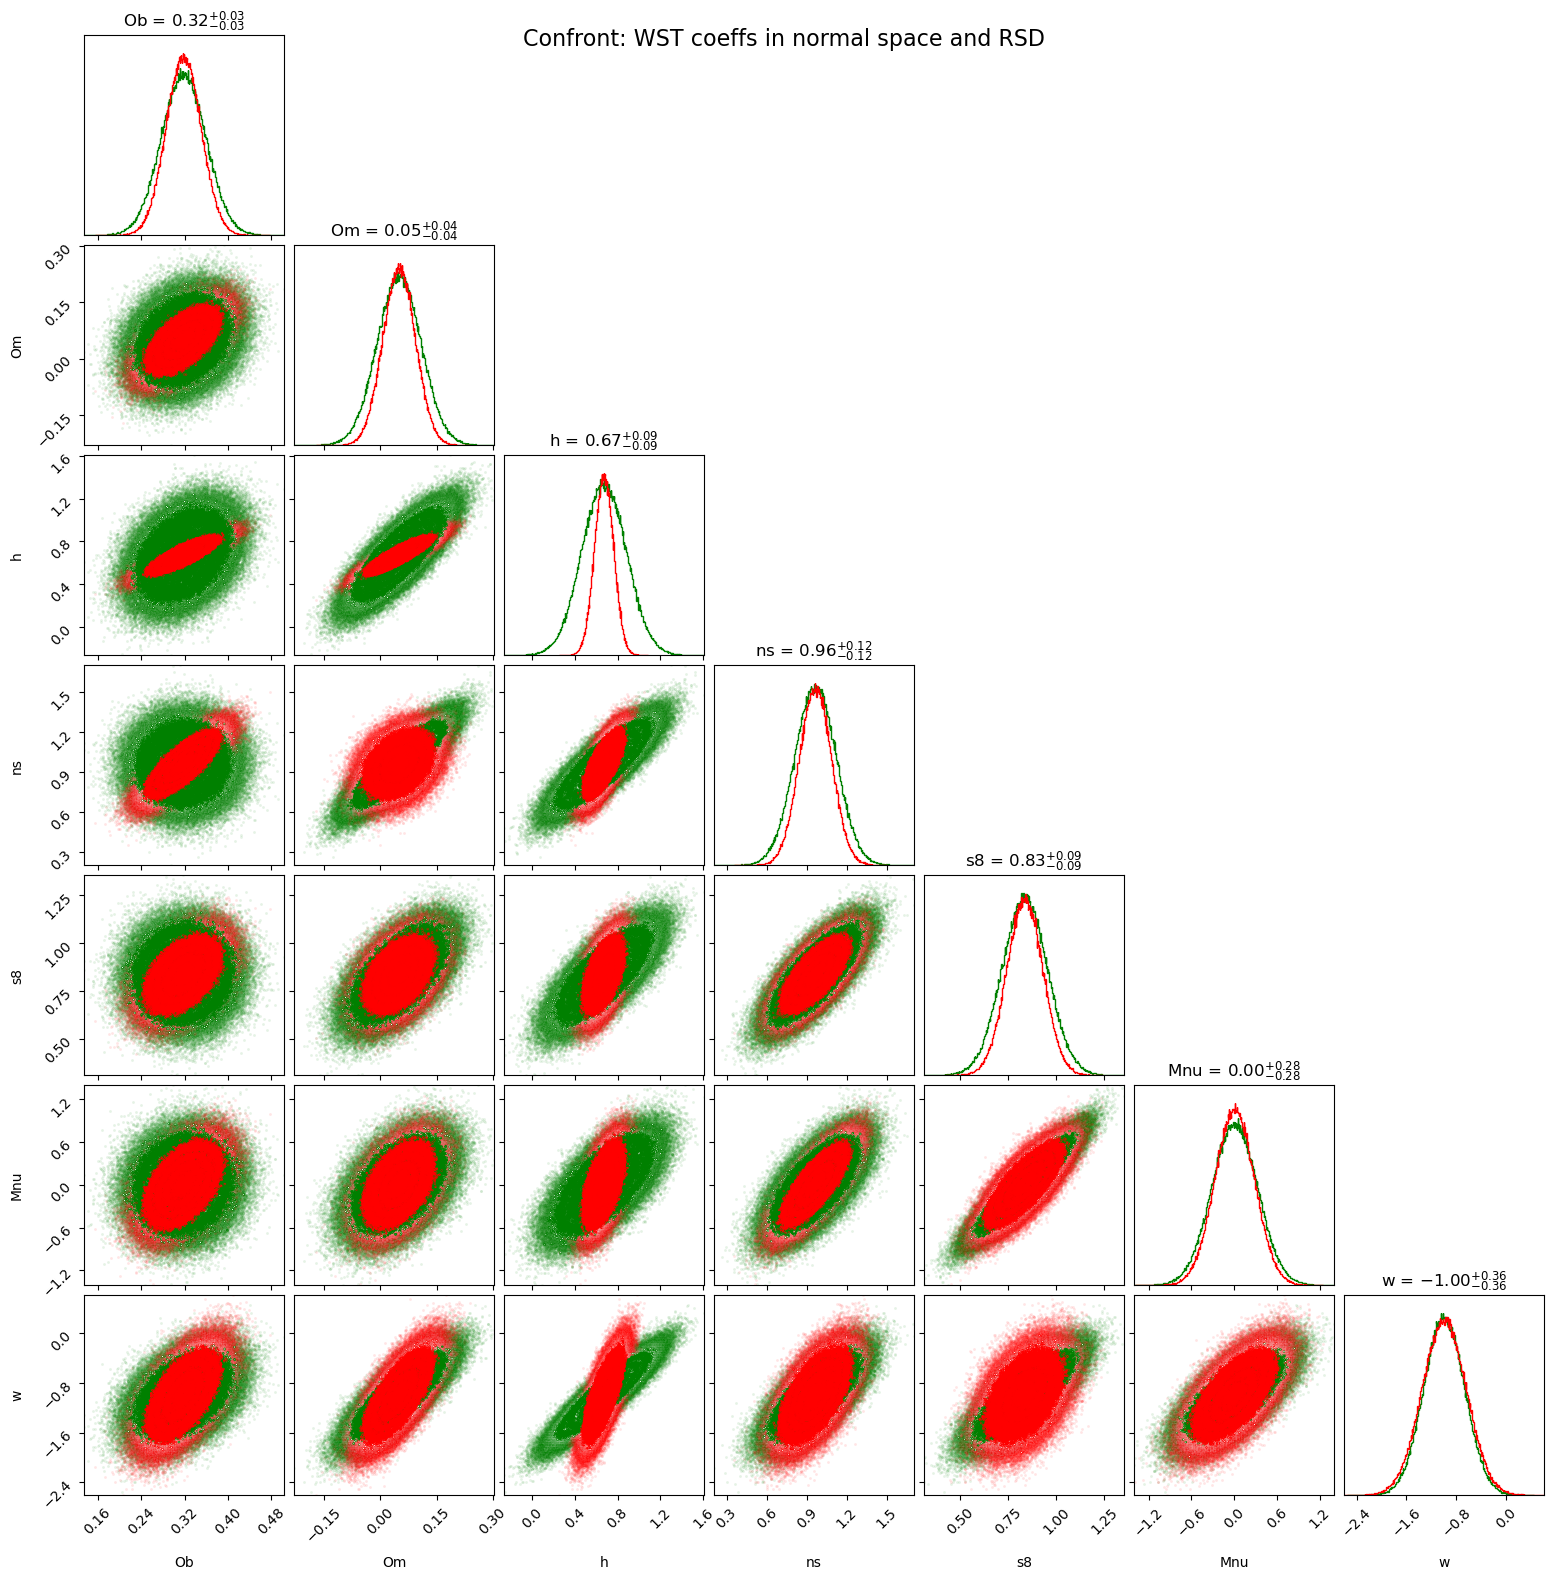

In [12]:
figure3 = corner.corner(data_wst_n, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu','w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"}
                       );
corner.corner(data_wst_rd, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                       fig=figure3)

figure3.suptitle('Confront: WST coeffs in normal space and RSD', fontsize=16)
plt.savefig("WST_coeffs_N-RSD.png")
plt.show();

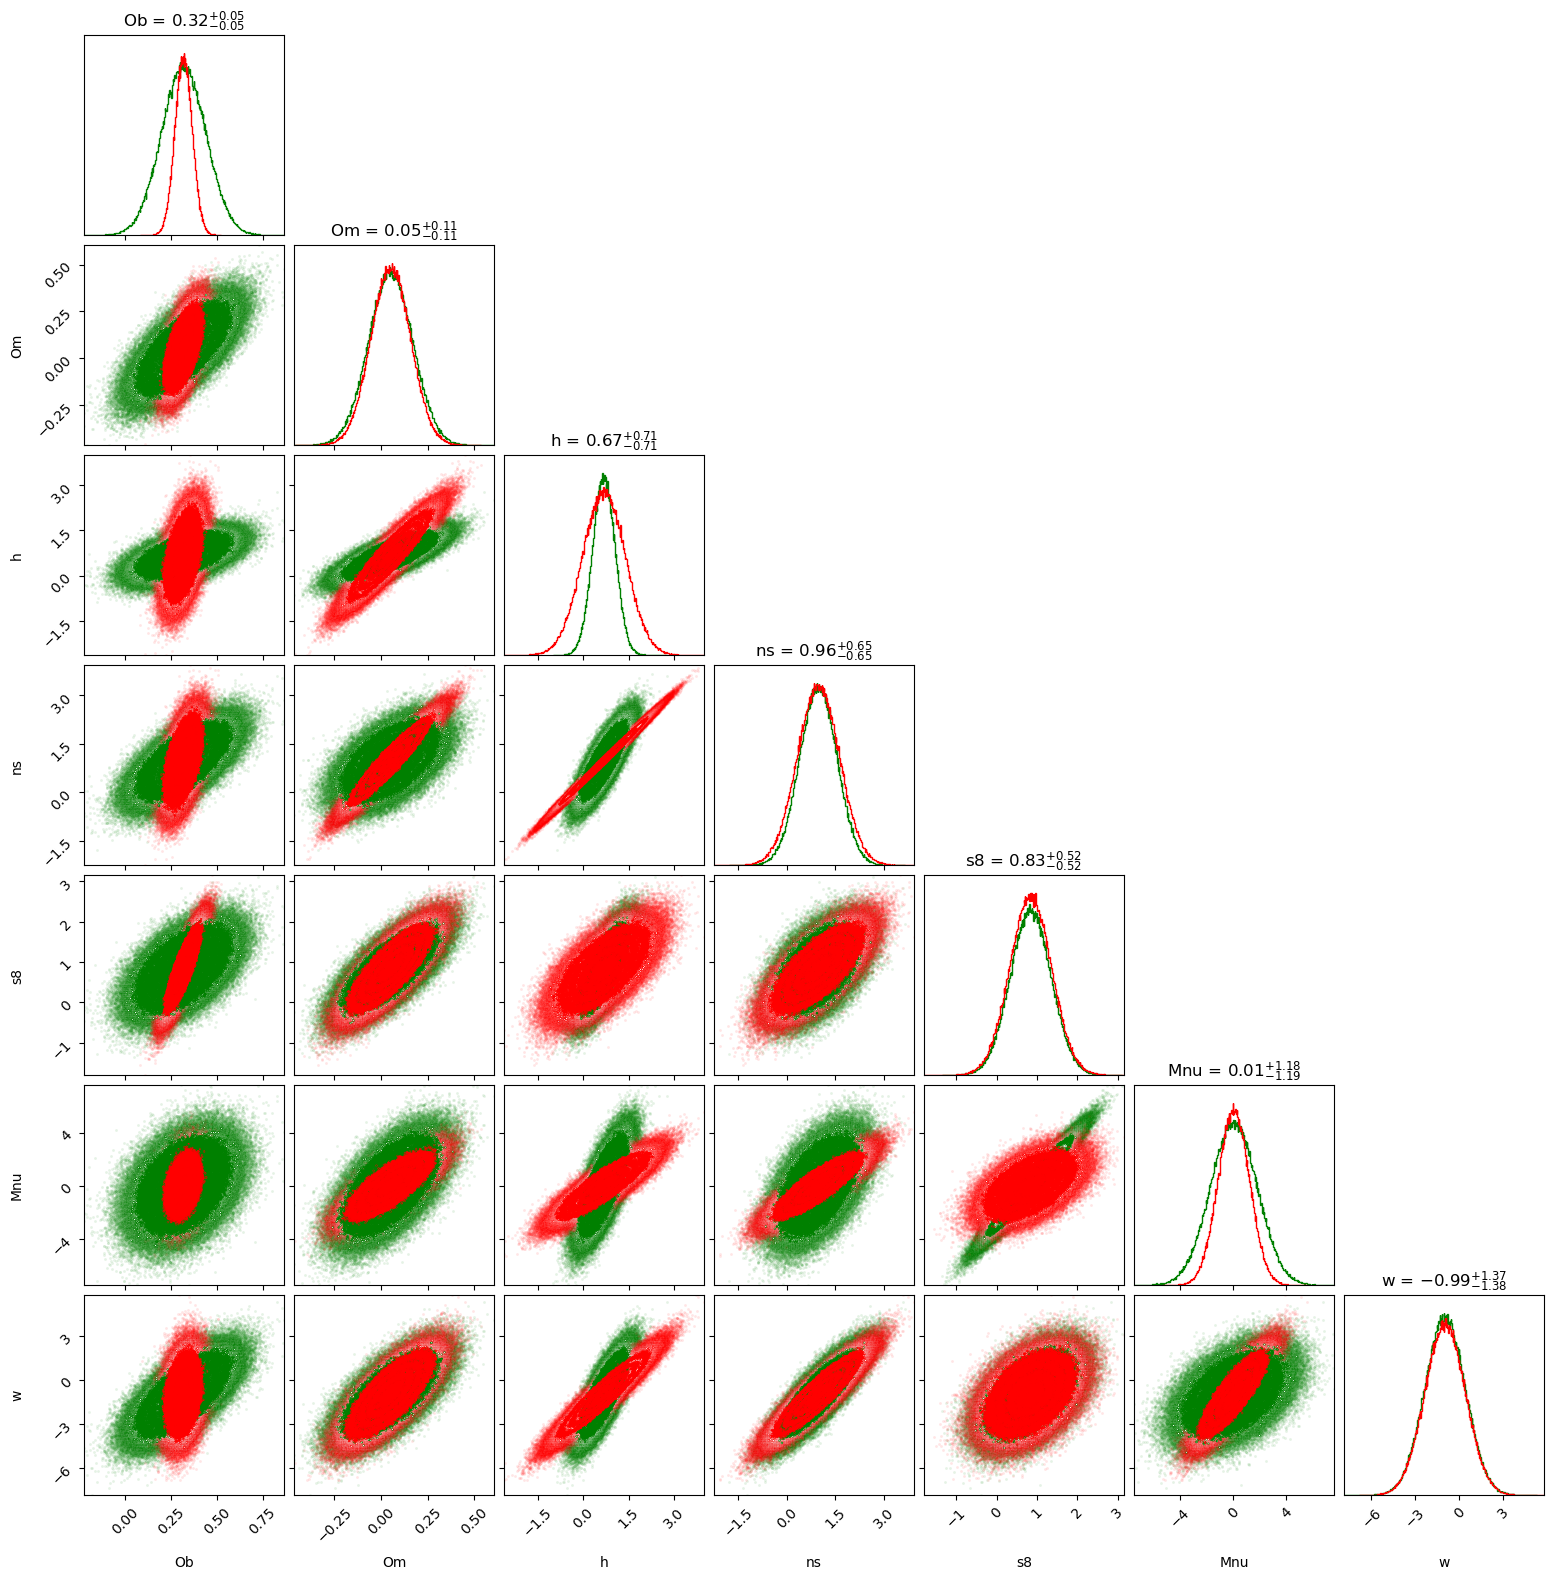

In [13]:
figure4 = corner.corner(data_pk_n, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu','w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='g', hist_kwargs={"color": "g"}, contour_kwargs={"colors": "g"}
                       );
corner.corner(data_pk_rd, labels=['Ob', 'Om', 'h', 'ns','s8', 'Mnu', 'w'], show_titles=True,
                       title_kwargs={"fontsize": 12},
                       bins = Bins,
                       # color='g', hist_kwargs={"color": "b"}, contour_kwargs={"colors": "r"})
                       color='r', hist_kwargs={"color": "r"}, contour_kwargs={"colors": "r"},
                       fig=figure4)

figure3.suptitle('Confront: PK coeffs in normal space and RSD', fontsize=16)
plt.savefig("PK_coeffs_N-RSD.png")
plt.show();

In [ ]:
break

# MUST CHANGE to 'venv' CONDA ENVIRONMENT

In [ ]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle

# If running from command line, above should be ran before
# importing normal_corner
import numpy as np
from normal_corner import normal_corner

In [ ]:
cons, cons_rsd = [], []
with open("./ZZ_results/constrains_pk.res", "rb") as f:
    while True:
        try:
            cons.append(pickle.load(f))
        except EOFError:
            break
with open("./ZZ_results/constrains_rsd_pk.res", "rb") as f:
    while True:
        try:
            cons_rsd.append(pickle.load(f))
        except EOFError:
            break

cons = cons[0]
cons_rsd = cons_rsd[0]
np.linalg.eig(cons)[0]

array([ 4.34411230e+00, -1.35519993e+00,  8.37438749e-02,  2.40940489e-02,
       -2.39418169e-02,  1.72331070e-04, -1.94516191e-03])

In [ ]:
cons2, cons_rsd2 = np.zeros((len(cons), len(cons))), np.zeros((len(cons), len(cons)))

for i in range(len(cons)):
    for j in range(len(cons)):
        cons2[i][j] = np.absolute(cons[i][j])
        cons2[j][i] = np.absolute(cons2[i][j])
        cons_rsd2[i][j] = np.absolute(cons_rsd[i][j])
        cons_rsd2[j][i] = np.absolute(cons_rsd2[i][j])

np.linalg.eig(cons2)[0]

array([ 4.34411230e+00, -1.35519993e+00,  8.37438749e-02,  2.40940489e-02,
       -2.39418169e-02,  1.72331070e-04, -1.94516191e-03])

In [ ]:
cons3, cons_rsd3 = np.zeros((len(cons), len(cons))), np.zeros((len(cons), len(cons)))

for i in range(len(cons)):
    for j in range(len(cons)):
        cons3[i][j] = cons[i][j]
        cons3[j][i] = cons3[i][j]
        cons_rsd3[i][j] = cons_rsd[i][j]
        cons_rsd3[j][i] = cons_rsd3[i][j]

np.linalg.eig(cons3)[0]

array([ 4.34411230e+00, -1.35519993e+00,  8.37438749e-02,  2.40940489e-02,
       -2.39418169e-02,  1.72331070e-04, -1.94516191e-03])

In [ ]:
mean_vals = np.array((0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1))

In [ ]:
varlabels = ['$\Omega_m$', '$\Omega_b$', '$h$', '$n_s$', '$s_8$', '$w$', '$M_{\nu}$']

In [ ]:
# `derivates` is an array whose i-th index
# refers to the derivates of a parameter